In [6]:
import os
import re
from typing import List, Set, Dict
from enum import Enum
from dataclasses import dataclass

@dataclass
class ExpSummary:
    """
    Class to summarize experiment results from a given directory.
    It extracts the experiment name, inference time, and training time.
    """
    path: os.PathLike

    @property
    def name(self) -> str:
        return os.path.basename(os.path.expanduser(self.path))
    @property
    def inference_time(self) -> float:
        return self.get_time_seconds(self.get_inference_time_path())
    @property
    def training_time(self) -> float:
        return self.get_time_seconds(self.get_training_time_path())
    
    @staticmethod
    def get_time_seconds(path: os.PathLike) -> float:
        """Extracts time in seconds from a given summary file."""
        with open(os.path.expanduser(path), 'r') as f:
            time_str = f.read().strip() # e.g., "get time: (123 seconds)"
        match = re.search(r'\((\d+)\s+seconds\)', time_str) # Match the number inside parentheses
        if match:
            return float(match.group(1))
        else:
            raise ValueError("Could not find time in seconds in the training summary file.")
    def get_inference_time_path(self) -> float:
        return os.path.join(self.path, "inference_summary.txt")
    def get_training_time_path(self) -> float:
        return os.path.join(self.path, "summary.txt")

# Create a Enums for different types
class NNodes(Enum):
    """
    Enum to represent different node configurations.
    Each member has a 'num' and an 'alias' attribute.
    """
    def __init__(self, num, alias):
        self.num = num
        self.alias = alias

    N14_9 = ("14_9", "5_4")
    N14_6 = ("14_6", "5_3")
    N20_9 = ("20_9", "6_4")
    N34_20 = ("34_20", "8_6")
    N52_27 = ("52_27", "10_7")
    N159_78 = ("159_78", "17_12")

    @classmethod
    def get(cls, key):
        """Get enum member by num, alias, or name."""
        for member in cls:
            if key in (member.num, member.alias, member.name):
                return member
        raise ValueError(f"{key} no corresponde a ningún miembro")

# Create a Enums for different types
class NEdges(Enum):
    """
    Enum to represent different edge configurations.
    Each member has a 'value' attribute.
    """
    one = 1
    two = 2
    three = 3
    four = 4
    five = 5

    @classmethod
    def get(cls, key):
        """Get enum member by value or name."""
        for member in cls:
            if key in (str(member.value), member.name):
                return member
        raise ValueError(f"{key} no corresponde a ningún miembro")

@dataclass
class ExpAggSummary:
    """
    Class to aggregate experiment summaries.
    """
    experiments_dir: str
    experiments_names: List[str]

    @property
    def summaries(self) -> List[ExpSummary]:
        """List of ExpSummary objects for each experiment name.
        """
        summaries = [
            ExpSummary(os.path.join(self.experiments_dir, exp_name))
            for exp_name in self.experiments_names
        ]
        return summaries

    @property
    def mesh_kinds(self) -> Set[str]:
        """Set of unique mesh kinds extracted from experiment names."""
        return set(
            exp.name.split('_m')[0] 
            for exp in self.summaries
            )
        
    def agg(self, by: str = "nodes") -> dict:
        """Aggregate experiments by a given feature (nodes or edges).
        """
        if by not in ["nodes", "edges"]:
            raise NotImplementedError(f"Aggregation by '{by}' not supported yet.")
        
        kinds = self.mesh_kinds

        d = {}
        for kind in kinds:
            # Filter experiments by kind
            filtered_exps = list(
                filter(lambda exp: exp.name.startswith(kind), self.summaries)
                )

            d[kind] = self._agg_by(filtered_exps, by)
        return d


    def _agg_by(self, exp_lst: List[ExpSummary], by: str) -> Dict[NNodes, ExpSummary]:
        """Aggregate experiments by a specific feature (nodes or edges).
        """
        d = {}
        for exp in exp_lst:
            # Extract configuration from experiment name
            node_cfg = self._get_config(exp.name, by=by)
            d[node_cfg.name] = exp
        return d

    def _get_config(self, exp_name: str, by: str) -> NNodes | NEdges:
        """Extract configuration from experiment name based on the feature (nodes or edges).
        """
        if by == "nodes": 
            # Extract number of nodes using regex
            match = re.search(r'\w+_m_(\d+_\d+)_g2mm2g_\d+', exp_name)
            feature = NNodes
        if by == "edges":
            # Extract number of edges using regex
            match = re.search(r'\w+_m_\d+_\d+_g2mm2g_(\d+)', exp_name)
            feature = NEdges

        if match:
            num_nodes = match.group(1)
            return feature.get(num_nodes)
        else:
            raise ValueError(f"Could not extract number of nodes from {exp_name} experiment name.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def get_slope(lead_day_scores):
    """Calculate the slope of lead day scores using linear regression."""
    X = np.arange(len(lead_day_scores)).reshape(-1,1)
    y = np.array(lead_day_scores)
    model = LinearRegression().fit(X, y)
    return model.coef_[0]  # Get the slope (coefficient)

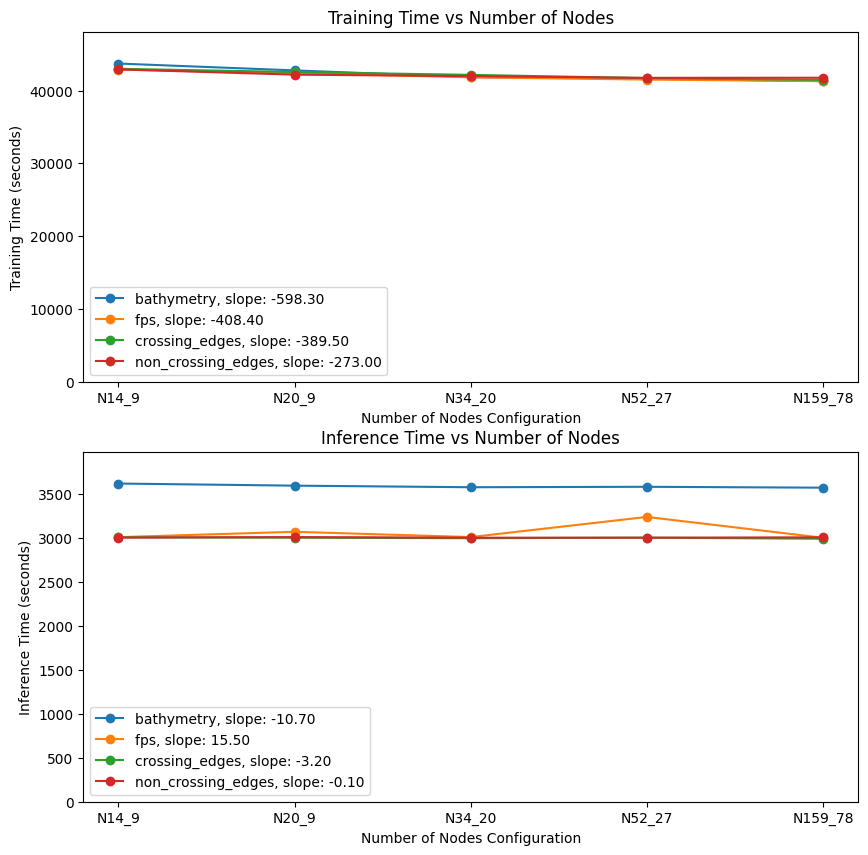

In [ ]:
experiments_dir = "~/Seacast/output/increase_n_nodes"
experiments_names = [
    'bathymetry_m_14_9_g2mm2g_4',
    'bathymetry_m_20_9_g2mm2g_4',
    'bathymetry_m_34_20_g2mm2g_4',
    'bathymetry_m_52_27_g2mm2g_4',
    'bathymetry_m_159_78_g2mm2g_4',
    'fps_m_14_9_g2mm2g_4',
    'fps_m_20_9_g2mm2g_4',
    'fps_m_34_20_g2mm2g_4',
    'fps_m_52_27_g2mm2g_4',
    'fps_m_159_78_g2mm2g_4',
    'crossing_edges_m_5_4_g2mm2g_4',
    'crossing_edges_m_6_4_g2mm2g_4',
    'crossing_edges_m_8_6_g2mm2g_4',
    'crossing_edges_m_10_7_g2mm2g_4',
    'crossing_edges_m_17_12_g2mm2g_4',
    'non_crossing_edges_m_5_4_g2mm2g_4',
    'non_crossing_edges_m_6_4_g2mm2g_4',
    'non_crossing_edges_m_8_6_g2mm2g_4',
    'non_crossing_edges_m_10_7_g2mm2g_4',
    'non_crossing_edges_m_17_12_g2mm2g_4',
    ]

# Aggregate experiments
experiments_summary = ExpAggSummary(experiments_dir, experiments_names).agg("nodes")

# Plotting
first_key = next(iter(experiments_summary))
node_cfg = list(experiments_summary[first_key].keys())
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
y_max_inference = []
y_max_training = []
# For each kind of mesh, plot training and inference times
for kind, summary in experiments_summary.items():
    training_times = [summary[nodes].training_time for nodes in node_cfg]
    y_max_training.append(max(training_times))
    inference_times = [summary[nodes].inference_time for nodes in node_cfg]
    y_max_inference.append(max(inference_times))

    axs[0].plot(node_cfg, training_times, marker='o', label=f"{kind}, slope: {get_slope(training_times):.2f}")
    axs[0].set_ylim(0, max(y_max_training) * 1.1)
    axs[1].plot(node_cfg, inference_times, marker='o', label=f"{kind}, slope: {get_slope(inference_times):.2f}")
    axs[1].set_ylim(0, max(y_max_inference) * 1.1)

axs[0].set_title('Training Time vs Number of Nodes')
axs[0].set_xlabel('Number of Nodes Configuration')
axs[0].set_ylabel('Training Time (seconds)')
axs[0].legend()
axs[1].set_title('Inference Time vs Number of Nodes')
axs[1].set_xlabel('Number of Nodes Configuration')
axs[1].set_ylabel('Inference Time (seconds)')
axs[1].legend()

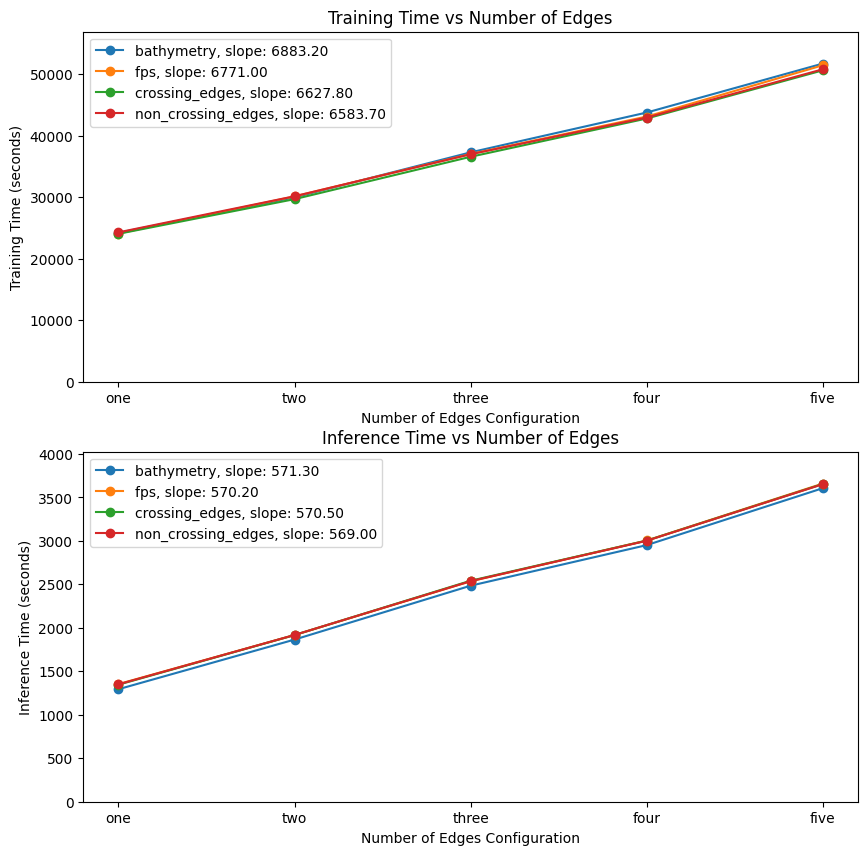

In [ ]:
experiments_dir = "~/Seacast/output/exps_g2m"
experiments_names = [
    'bathymetry_m_14_6_g2mm2g_1',
    'bathymetry_m_14_6_g2mm2g_2',
    'bathymetry_m_14_6_g2mm2g_3',
    'bathymetry_m_14_6_g2mm2g_4',
    'bathymetry_m_14_6_g2mm2g_5',
    'fps_m_14_6_g2mm2g_1',
    'fps_m_14_6_g2mm2g_2',
    'fps_m_14_6_g2mm2g_3',
    'fps_m_14_6_g2mm2g_4',
    'fps_m_14_6_g2mm2g_5',
    'crossing_edges_m_5_3_g2mm2g_1',
    'crossing_edges_m_5_3_g2mm2g_2',
    'crossing_edges_m_5_3_g2mm2g_3',
    'crossing_edges_m_5_3_g2mm2g_4',
    'crossing_edges_m_5_3_g2mm2g_5',
    'non_crossing_edges_m_5_3_g2mm2g_1',
    'non_crossing_edges_m_5_3_g2mm2g_2',
    'non_crossing_edges_m_5_3_g2mm2g_3',
    'non_crossing_edges_m_5_3_g2mm2g_4',
    'non_crossing_edges_m_5_3_g2mm2g_5',
    ]

# Aggregate experiments
experiments_summary = ExpAggSummary(experiments_dir, experiments_names).agg("edges")

# Plotting
first_key = next(iter(experiments_summary))
node_cfg = list(experiments_summary[first_key].keys())
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
y_max_inference = []
y_max_training = []
# For each kind of mesh, plot training and inference times
for kind, summary in experiments_summary.items():
    training_times = [summary[nodes].training_time for nodes in node_cfg]
    y_max_training.append(max(training_times))
    inference_times = [summary[nodes].inference_time for nodes in node_cfg]
    y_max_inference.append(max(inference_times))

    axs[0].plot(node_cfg, training_times, marker='o', label=f"{kind}, slope: {get_slope(training_times):.2f}")
    axs[0].set_ylim(0, max(y_max_training) * 1.1)
    axs[1].plot(node_cfg, inference_times, marker='o', label=f"{kind}, slope: {get_slope(inference_times):.2f}")
    axs[1].set_ylim(0, max(y_max_inference) * 1.1)
    
axs[0].set_title('Training Time vs Number of Edges')
axs[0].set_xlabel('Number of Edges Configuration')
axs[0].set_ylabel('Training Time (seconds)')
axs[0].legend()
axs[1].set_title('Inference Time vs Number of Edges')
axs[1].set_xlabel('Number of Edges Configuration')
axs[1].set_ylabel('Inference Time (seconds)')
axs[1].legend()

In [13]:
node_cfg

['one', 'two', 'three', 'four', 'five']

In [23]:
type(list(list(experiments_summary.values())[0].values())[0])

__main__.ExpSummary

In [24]:
# For each kind of mesh, define a dataframe
import pandas as pd

def create_summary_table(
        experiments_summary: Dict[str, Dict[str, ExpSummary]], 
        node_cfg: List[str]
        ) -> (pd.DataFrame, pd.DataFrame):
    """Create a summary table for training and inference times."""
    df_train = pd.DataFrame()
    df_inference = pd.DataFrame()
    # Define index
    for kind, summary in experiments_summary.items():
        training_times = [summary[nodes].training_time for nodes in node_cfg]
        inference_times = [summary[nodes].inference_time for nodes in node_cfg]
        df_train[kind] = training_times
        df_inference[kind] = inference_times
    return df_train, df_inference

df_train, df_inference = create_summary_table(experiments_summary, node_cfg)

df_train, df_inference

(   bathymetry      fps  crossing_edges  non_crossing_edges
 0     24211.0  24086.0         24045.0             24280.0
 1     29969.0  30128.0         29682.0             30151.0
 2     37293.0  37018.0         36571.0             36982.0
 3     43767.0  43114.0         42794.0             42946.0
 4     51728.0  51448.0         50628.0             50801.0,
    bathymetry     fps  crossing_edges  non_crossing_edges
 0      1294.0  1353.0          1346.0              1350.0
 1      1865.0  1917.0          1917.0              1918.0
 2      2485.0  2536.0          2542.0              2537.0
 3      2952.0  3005.0          3004.0              3002.0
 4      3607.0  3660.0          3655.0              3653.0)